# Evaluation of 5 machine learning algorithm

In [1]:
#Loading data
import pandas as pd
import numpy as np
import warnings

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#other models
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 

#plots
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from collections import OrderedDict

cmaps = OrderedDict()

#metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

#cross validations
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

# Define random state
random_state = 2019
np.random.seed(random_state)
warnings.filterwarnings('ignore')

#librerias de sistema
import os



# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 8
    }

plt.rc('font', **font)

In [2]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred

    
#plot for results   
tar_names=['vacio','bosque montano de hoja perenne','Bosque seco tropical y subtropical de frondosas','humid Puna',
          'Paramo','matorral montano','xeric pre-puna','Glaciar','xeric puna',
          'bosque yunga','pantano']
def show_field(field1,field2):
    
    combined_data = np.array([field1,field2])
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(15,20))
    ax = fig.add_subplot(1, 2, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1,cmap='tab20b', vmin = _min, vmax = _max)
    #ax.set_adjustable('box-forced')
    ax.autoscale(False)
    ax2 = fig.add_subplot(1, 2, 2)
    #ax2.set_adjustable('box-forced')
    #Add the vmin and vmax arguments to set the color scale
    im=ax2.imshow(field2,cmap='tab20b', vmin = _min, vmax = _max)
    ax2.autoscale(False)
    
    values=np.unique(field2)
    colors = [ im.cmap(im.norm(value)) for value in np.unique(result)]
    #patches = [ mpatches.Patch(color=colors[i], label="Bioma {l}".format(l=values[i]) ) for i in range(len(values)) ]
    patches = [ mpatches.Patch(color=colors[i], label=tar_names[i] ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. ,title='Biomes',fontsize=12,title_fontsize=15)
    
    plt.show()
    pass

#Function for saving results
def writeRaster(array,GeoTransform,name):
    nrows,ncols=array.shape
    output_raster = gdal.GetDriverByName('GTiff').Create(name,ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(GeoTransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
    output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system
    output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster
    output_raster.FlushCache()    



In [3]:
def subseting(Y,covariable,type='M'):
    covariable['id']=np.arange(covariable.shape[0])
    covariable=covariable.dropna()
    Y=Y[covariable.id]
    covariable=covariable.drop('id',axis=1)
    
    
    #cond=(Y==1) | (Y==2)| (Y==3)| (Y==4)| (Y==5)| (Y==6) | (Y==8) | (Y==9)
    cond=(Y==1) | (Y==2)| (Y==3)| (Y==4)| (Y==5)| (Y==6) | (Y==8) | (Y==9) | (Y==13) | (Y==14)
    target=Y[cond]
    features=covariable.loc[cond,:]
    
    
    if type!='N':
        xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.30, random_state=42)
    else:
        # load data
        data = features
        # create scaler
        scaler = MinMaxScaler()
        # fit scaler on data
        scaler.fit(data)
        # apply transform
        normalized = scaler.transform(data)
        
        target=pd.get_dummies(target)#tensorflow.keras.utils.to_categorical(target)
        xtrain, xtest, ytrain, ytest = train_test_split(normalized, target, test_size=0.35, random_state=42)
        
    if type=='PCA':
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=.95))])
        BioPCA=pipeline.fit_transform(features)
        PCABIO=pd.DataFrame(BioPCA,columns=['PC1','PC2','PC3','PC4'])
        xtrain, xtest, ytrain, ytest = train_test_split(PCABIO, target, test_size=0.30, random_state=42)
    
    return (xtrain,ytrain,xtest,ytest)

In [4]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
explanatory_rasters = os.listdir("predictores/")
response_data = 'biomas.tif'


def predictions(x,model,target,tipo='MM'):
    if tipo=='MM':
        result=model.predict(x.dropna())
        target[list(x.dropna().index)]=result 
    else:
        clases={0:1,1:2,2:3,3:4,4:5,5:6,6:8,7:9,8:13,9:14}
        
        data = x
        # create scaler
        scaler = MinMaxScaler()
        # fit scaler on data
        scaler.fit(data)
        # apply transform
        normalized = scaler.transform(data)
        x=pd.DataFrame(normalized)
        result=model.predict(x.dropna())
        clase=result.argmax(axis=-1)
        target[list(x.dropna().index)]=clase
        target=np.vectorize(clases.get)(target)
    return target


In [5]:
# Read in our predictors into img_ds and ROI is the current biome configuration

img_ds=[gdal.Open('predictores/'+pred, gdal.GA_ReadOnly) for pred in explanatory_rasters]   

roi_ds = gdal.Open('biomas.tif', gdal.GA_ReadOnly)

#saving the image as arrays
img = [img_ds[i].GetRasterBand(1).ReadAsArray() for i in range(len(img_ds))]
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

#### Reshaping the predictor into a big array

In [6]:
n,m=img[1].shape
target=np.zeros((n*m))
predictores=[]
for i in range(len(img)):
    predictores.append(img[i].reshape(n*m))


#las columnas son los datos de los rasters
covariable=pd.DataFrame(np.concatenate([predictores])).transpose()
#nombre de las columnas
covariable.columns=[explanatory_rasters[i].split('.')[0] for i in range(len(explanatory_rasters))]
#cleanning negative values in predictors
covariable[covariable<-100]=np.nan

#Droping columns
data=covariable.dropna()
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop.remove('dem')

In [7]:
X,Y,Xtest,Ytest=subseting(np.reshape(roi,(n*m)),covariable.drop(to_drop,axis=1))

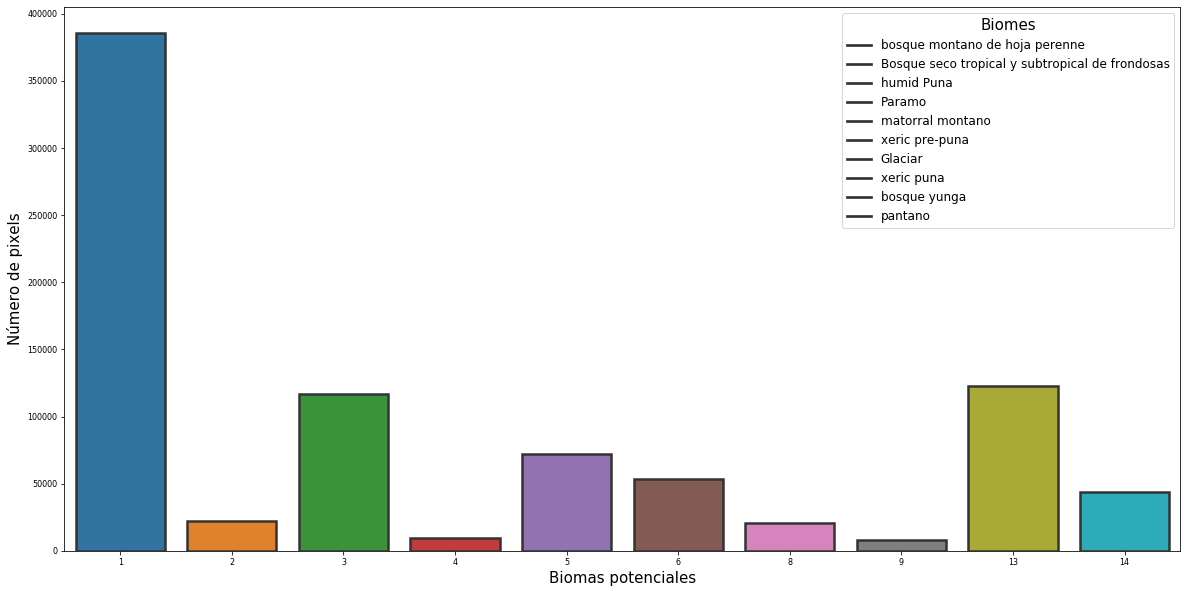

In [10]:
label,count=np.unique(Y, return_counts=True)
# plt.bar(class_name, count)
plt.figure(figsize=(20,10))
im=sns.barplot(x=label, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Biomas potenciales', fontsize=15)
plt.ylabel('Número de pixels', fontsize=15)
#plt.title('Data distribution',fontsize=20)
#plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.legend(tar_names[1:11],title='Biomes',fontsize=12,title_fontsize=15)
plt.show()

# Best parameters grid search for RF

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)

rdf = RandomForestClassifier(random_state = random_state) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10, 20,30], 
              'min_samples_split': [5, 10, 15,20],
              'min_samples_leaf' : [4, 8, 12,16],
              'n_estimators' : [300, 400, 500]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X, Y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 335.7min


In [ ]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

# Weigthed RF

In [194]:

class_weight = dict({1:1, 2:17, 3:3,4:36,5:5,6:7,8:18,9:43,13:3,14:8})

rdf = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

In [195]:
base_models = [rdf]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)     

In [196]:
train_proba, test_proba, train_pred, test_pred = lgb_stack.predict(X, Y, Xtest)

Model- 0 and CV- 0 recall: 0.8966405549521852, f1_score: 0.8438109246021496
Model- 0 and CV- 1 recall: 0.8940460287796179, f1_score: 0.8407676012848915
Model- 0 and CV- 2 recall: 0.8932618751939826, f1_score: 0.8414371361499381
Model- 0 and CV- 3 recall: 0.896754938201561, f1_score: 0.8426149429995717
Model- 0 and CV- 4 recall: 0.8936596857434042, f1_score: 0.8398147263544704


In [197]:
print('1. The F-1 score of the model {}\n'.format(f1_score(Y, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(Y, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(Y, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(Y, train_pred)))

1. The F-1 score of the model 0.8416833603934997

2. The recall score of the model 0.8948724926427492

3. Classification report 
               precision    recall  f1-score   support

           1       0.98      0.90      0.94    385602
           2       0.79      0.92      0.85     22154
           3       0.91      0.86      0.88    116630
           4       0.59      0.91      0.72      9842
           5       0.87      0.85      0.86     72407
           6       0.95      0.96      0.96     53220
           8       0.68      0.79      0.73     20762
           9       0.75      0.90      0.82      8360
          13       0.92      0.95      0.93    122448
          14       0.62      0.90      0.73     43863

    accuracy                           0.90    855288
   macro avg       0.80      0.89      0.84    855288
weighted avg       0.91      0.90      0.90    855288
 

4. Confusion matrix 
 [[347871   2551   1151    331   1040    349    244     69   7610  24386]
 [    68  2030

In [198]:
rdf.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={1: 1, 2: 17, 3: 3, 4: 36, 5: 5, 6: 7,
                                     8: 18, 9: 43, 13: 3, 14: 8},
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=2019, verbose=0,
                       warm_start=False)

In [200]:
#covariable=covariable.drop('id',axis=1)
result=predictions(covariable.drop(to_drop,axis=1),rdf,target).reshape(n,m)

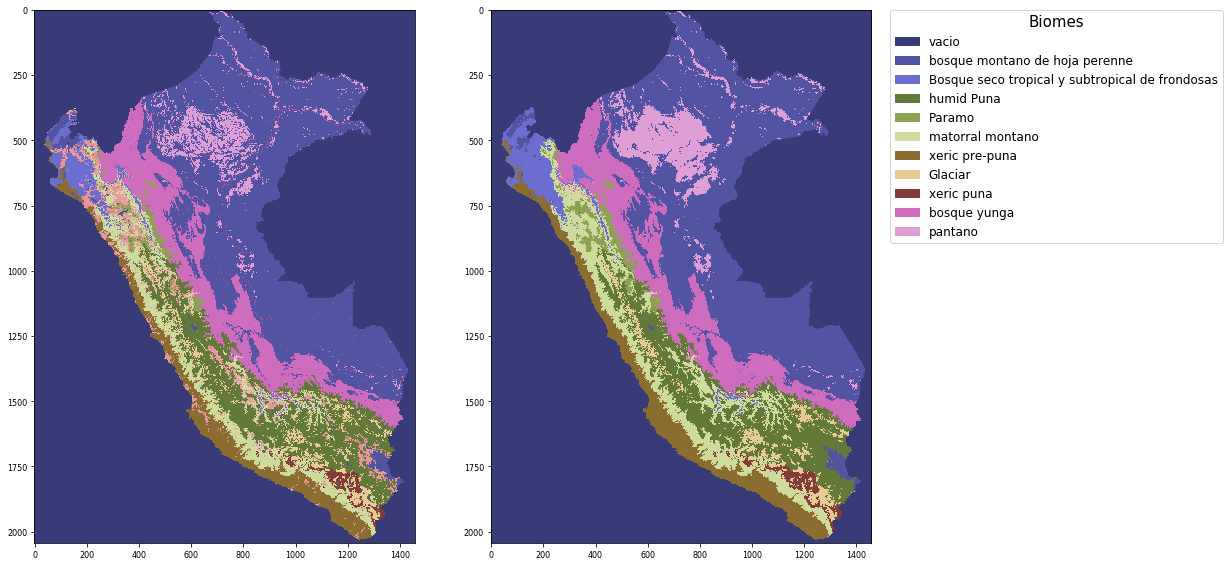

In [201]:
show_field(roi,result)

In [21]:
#Saving results
writeRaster(result,roi_ds.GetGeoTransform(),'BiomasRFo.tif')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


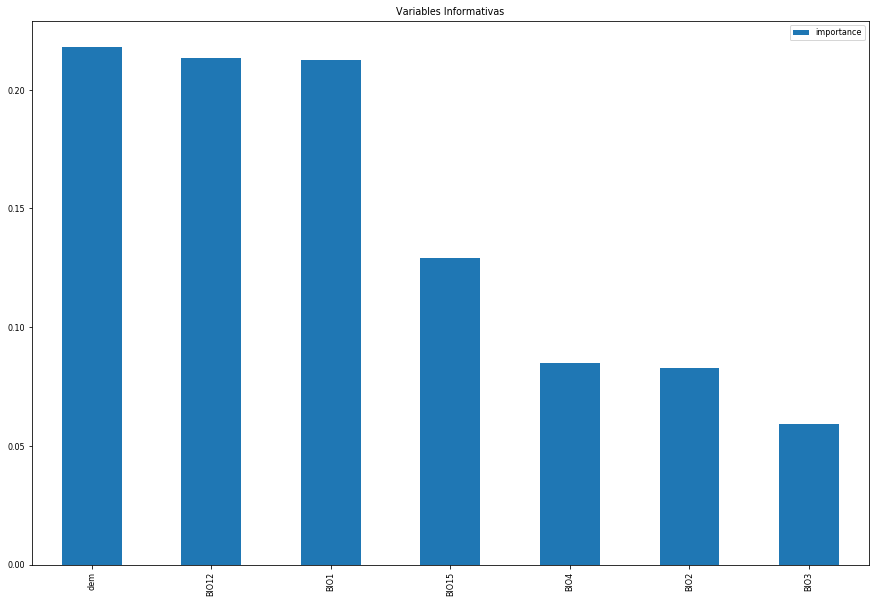

In [202]:
feature_imporanteces=pd.DataFrame(rdf.feature_importances_,index=X.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_imporanteces.plot.bar(figsize=(15,10))
plt.title('Variables Informativas')
plt.show()

# Testing other classifiers

<b>Support vector Machine

Grid search 

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)

svm_model_linear = SVC(kernel = 'linear')
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'C': [0.001, 0.01, 0.1, 1, 10], 
              'gamma': [0.001, 0.01, 0.1, 1]
             }

grid_clf = GridSearchCV(estimator = svm_model_linear, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X, Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 33.3min


In [27]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

In [ ]:
svm_model_linear = SVC(kernel = 'linear', C = 0.1, gamma=1).fit(X, Y) 
train_pred = svm_model_linear.predict(X)
print('1. The F-1 score of the model {}\n'.format(f1_score(Y, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(Y, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(Y, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(Y, train_pred)))

In [ ]:
#covariable=covariable.drop('id',axis=1)
result=predictions(covariable.drop(to_drop,axis=1),svm_model_linear,target).reshape(n,m)
show_field(roi,result)

<b> KNN

In [190]:
k=3
knn = KNeighborsClassifier(n_neighbors = k).fit(X, Y)
train_pred = knn.predict(X)
print('1. The F-1 score of the model {}\n'.format(f1_score(Y, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(Y, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(Y, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(Y, train_pred)))

1. The F-1 score of the model 0.8700707171851265

2. The recall score of the model 0.8599276632947024

3. Classification report 
               precision    recall  f1-score   support

           1       0.96      0.96      0.96    385602
           2       0.89      0.90      0.89     22154
           3       0.88      0.94      0.91    116630
           4       0.77      0.72      0.74      9842
           5       0.89      0.86      0.88     72407
           6       0.97      0.97      0.97     53220
           8       0.84      0.73      0.78     20762
           9       0.86      0.80      0.83      8360
          13       0.94      0.94      0.94    122448
          14       0.82      0.78      0.80     43863

    accuracy                           0.93    855288
   macro avg       0.88      0.86      0.87    855288
weighted avg       0.93      0.93      0.93    855288
 

4. Confusion matrix 
 [[371495    490    756     81    600    111     65     13   4606   7385]
 [   557  1993

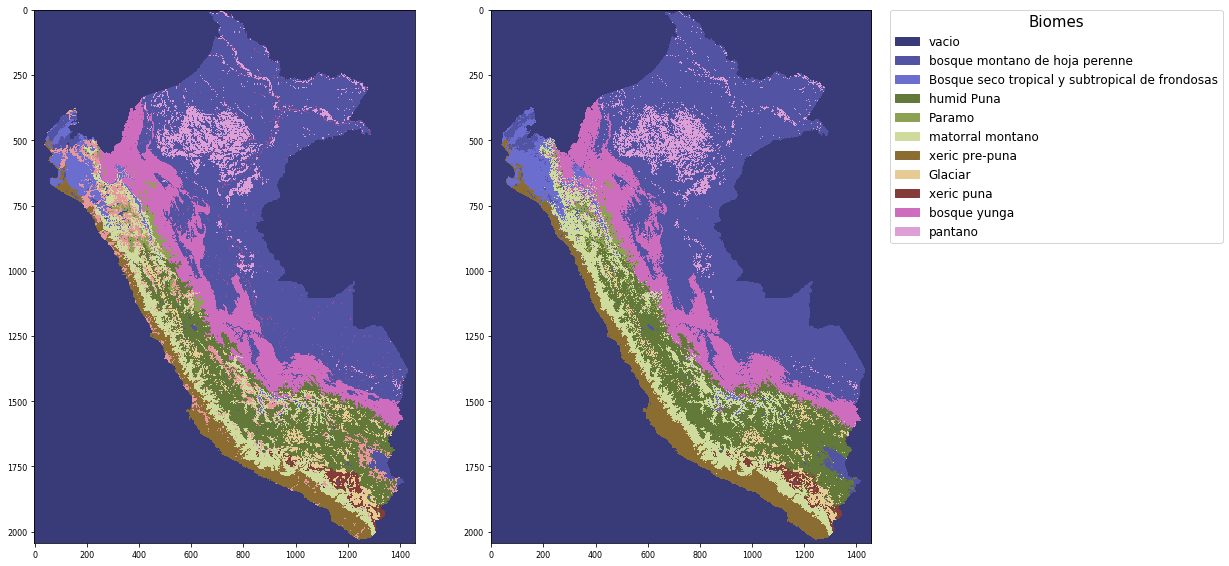

In [193]:
#covariable=covariable.drop('id',axis=1)
result=predictions(covariable.drop(to_drop,axis=1),knn,target).reshape(n,m)
show_field(roi,result)

<b> Neural network 

In [25]:
X,Y,Xtest,Ytest=subseting(np.reshape(roi,(n*m)),covariable,type='N')

In [26]:
model = Sequential()
model.add(Dense(500,input_dim=X.shape[1],activation='relu',kernel_initializer='random_normal'))
model.add(Dense(250,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(Y.shape[1],activation='softmax'))
model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)


model.fit(X,Y,validation_data=(Xtest,Ytest),callbacks=[monitor],verbose=2,epochs=1000)



Train on 771276 samples, validate on 415303 samples
Epoch 1/1000
771276/771276 - 70s - loss: 0.0806 - accuracy: 0.9673 - val_loss: 0.0742 - val_accuracy: 0.9694
Epoch 2/1000
771276/771276 - 66s - loss: 0.0700 - accuracy: 0.9711 - val_loss: 0.0677 - val_accuracy: 0.9721
Epoch 3/1000
771276/771276 - 67s - loss: 0.0665 - accuracy: 0.9725 - val_loss: 0.0679 - val_accuracy: 0.9716
Epoch 4/1000
771276/771276 - 65s - loss: 0.0642 - accuracy: 0.9733 - val_loss: 0.0631 - val_accuracy: 0.9739
Epoch 5/1000
771276/771276 - 65s - loss: 0.0625 - accuracy: 0.9740 - val_loss: 0.0650 - val_accuracy: 0.9730
Epoch 6/1000
771276/771276 - 67s - loss: 0.0614 - accuracy: 0.9744 - val_loss: 0.0586 - val_accuracy: 0.9756
Epoch 7/1000
771276/771276 - 62s - loss: 0.0604 - accuracy: 0.9747 - val_loss: 0.0596 - val_accuracy: 0.9748
Epoch 8/1000
771276/771276 - 62s - loss: 0.0596 - accuracy: 0.9751 - val_loss: 0.0596 - val_accuracy: 0.9755
Epoch 9/1000
771276/771276 - 62s - loss: 0.0588 - accuracy: 0.9754 - val_los

In [27]:
covariable=covariable.drop('id',axis=1)

In [28]:
import time
start_time = time.time()
result1=predictions(covariable,model,target,tipo='NN').reshape(n,m)
print("--- %s seconds ---" % (time.time() - start_time))

--- 32.61448049545288 seconds ---


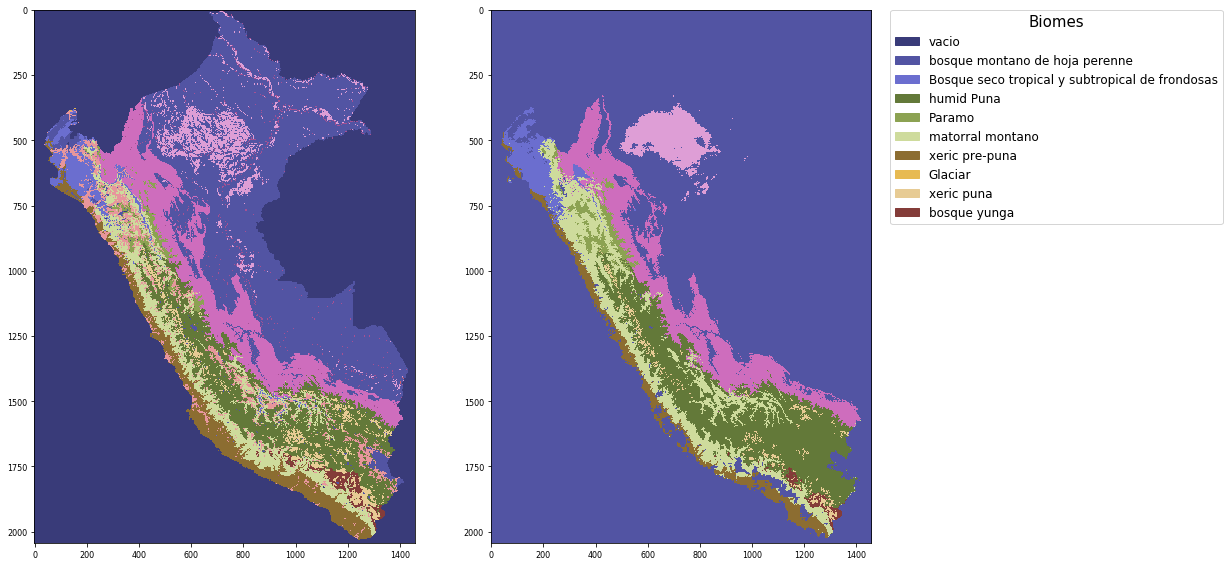

In [29]:
show_field(roi,result1)

# Model Projections

In [28]:
clases={0:1,1:2,2:3,3:4,4:5,5:6,6:8,7:9,8:13,9:14}
result = model.predict(X)
train_pred =result.argmax(axis=-1)
train_pred=np.vectorize(clases.get)(train_pred)
Y=Y.idxmax(axis=1)

In [29]:
print('1. The F-1 score of the model {}\n'.format(f1_score(Y, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(Y, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(Y, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(Y, train_pred)))

1. The F-1 score of the model 0.6896685544952685

2. The recall score of the model 0.6841716086058743

3. Classification report 
               precision    recall  f1-score   support

           1       0.89      0.94      0.92     11752
           2       0.68      0.78      0.73       660
           3       0.78      0.86      0.82      3522
           4       0.58      0.65      0.62       324
           5       0.79      0.68      0.73      2202
           6       0.89      0.92      0.91      1649
           8       0.59      0.66      0.62       630
           9       0.79      0.28      0.41       269
          13       0.86      0.89      0.87      3748
          14       0.65      0.18      0.28      1317

    accuracy                           0.84     26073
   macro avg       0.75      0.68      0.69     26073
weighted avg       0.83      0.84      0.83     26073
 

4. Confusion matrix 
 [[11070   118   144     9    20     5     7     0   254   125]
 [   14   518     0     